## Predict the overall rating of soccer player
Data used here came from Kaggle dataset of European Soccer Database

In [49]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import pyarrow.parquet as pq
import numpy as np
from scipy import stats

In [7]:
#Reading parquet file data
## Converting parquet file to pandas dataframe
data = pq.read_pandas('soccer.parquet').to_pandas()
data.head()

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
id,,,,,,,,,,,,,,,,,,,,,
1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [10]:
##Checking for missing data
print(data.isna().sum())


player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle      

#### Dropping missing data

In [11]:
len(data),len(data.dropna())

(183978, 180354)

In [46]:
data = data.dropna()

### Visualizing the data

<AxesSubplot:ylabel='Frequency'>

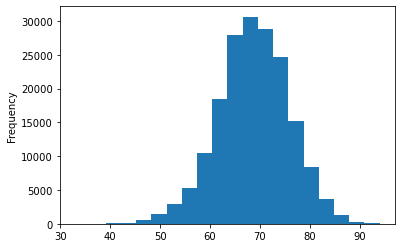

In [13]:
data['overall_rating'].plot.hist(bins = 20)

In [14]:
data['overall_rating'].describe()

count    180354.000000
mean         68.635317
std           7.027950
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

#### Selecting important features

In [19]:
data.corr()['overall_rating'].sort_values(ascending = False)

overall_rating        1.000000
reactions             0.771856
potential             0.765435
short_passing         0.458243
ball_control          0.443991
long_passing          0.434525
vision                0.431493
shot_power            0.428053
penalties             0.392715
long_shots            0.392668
positioning           0.368978
volleys               0.361739
curve                 0.357566
crossing              0.357320
dribbling             0.354191
free_kick_accuracy    0.349800
finishing             0.330079
stamina               0.325606
aggression            0.322782
strength              0.315684
heading_accuracy      0.313324
jumping               0.258978
sprint_speed          0.253048
interceptions         0.249094
acceleration          0.243998
agility               0.239963
standing_tackle       0.163986
balance               0.160211
marking               0.132185
sliding_tackle        0.128054
gk_kicking            0.028799
gk_diving             0.027675
gk_posit

#### Dropping worst correlated features

In [82]:
data_modify = data.drop(['balance' ,'marking', 'sliding_tackle', 'gk_kicking','gk_diving', 'gk_positioning', 'gk_reflexes', 'gk_handling', 'player_fifa_api_id','player_api_id'],axis=1)
#Selecting only numeric columns
data_modify = data_modify.select_dtypes(include = 'number')

#### Checking for outliers and removing them

In [83]:
data_modify

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,standing_tackle
id,,,,,,,,,,,,,,,,,,,,,
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,69.0
2,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,69.0
3,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,66.0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,63.0
5,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183974,83.0,85.0,84.0,77.0,59.0,89.0,77.0,84.0,86.0,78.0,...,58.0,72.0,67.0,81.0,56.0,78.0,86.0,88.0,83.0,31.0
183975,78.0,80.0,74.0,76.0,53.0,84.0,77.0,85.0,86.0,74.0,...,58.0,66.0,65.0,73.0,61.0,64.0,72.0,88.0,70.0,31.0
183976,77.0,80.0,74.0,71.0,53.0,84.0,77.0,85.0,86.0,74.0,...,58.0,66.0,65.0,73.0,67.0,64.0,72.0,88.0,70.0,31.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a94de3d130>,
 'caps': [<matplotlib.lines.Line2D at 0x1a94de3d6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a94de2be20>,
 'medians': [<matplotlib.lines.Line2D at 0x1a94de3dc70>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a94de3df40>,
 'means': []}

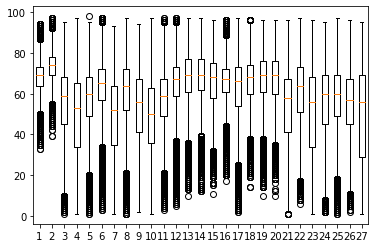

In [84]:
plt.boxplot(data_modify)

In [85]:
#Removing outliers
data_modify =data_modify[(np.abs(stats.zscore(data_modify)) < 3).all(axis=1)]

{'whiskers': [<matplotlib.lines.Line2D at 0x1a94db110a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a94e004400>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a94db11fa0>,
 'medians': [<matplotlib.lines.Line2D at 0x1a94db21a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a94db218b0>,
 'means': []}

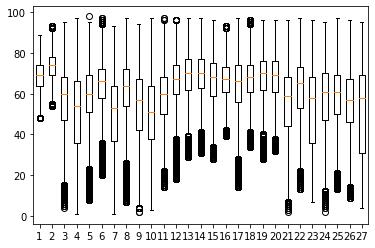

In [86]:
plt.boxplot(data_modify)

In [87]:
#Dropping Duplicates
data_modify = data_modify.drop_duplicates()
data_modify

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,standing_tackle
id,,,,,,,,,,,,,,,,,,,,,
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,69.0
3,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,66.0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,63.0
6,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,...,85.0,79.0,56.0,62.0,68.0,67.0,60.0,66.0,59.0,75.0
7,74.0,76.0,80.0,53.0,58.0,71.0,32.0,73.0,70.0,69.0,...,85.0,79.0,56.0,60.0,68.0,67.0,60.0,66.0,59.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183974,83.0,85.0,84.0,77.0,59.0,89.0,77.0,84.0,86.0,78.0,...,58.0,72.0,67.0,81.0,56.0,78.0,86.0,88.0,83.0,31.0
183975,78.0,80.0,74.0,76.0,53.0,84.0,77.0,85.0,86.0,74.0,...,58.0,66.0,65.0,73.0,61.0,64.0,72.0,88.0,70.0,31.0
183976,77.0,80.0,74.0,71.0,53.0,84.0,77.0,85.0,86.0,74.0,...,58.0,66.0,65.0,73.0,67.0,64.0,72.0,88.0,70.0,31.0


### Splitting data into training and test datasets

In [88]:
x = data_modify.drop('overall_rating',axis=1)
y = data_modify['overall_rating']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3 , random_state = 42)

#### Training our model with 70% of dataset

In [89]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

### Evaluating the Model with R2-score

In [90]:

y_predict = model.predict(x_test)
r2_score(y_test,y_predict)

0.7945192691683505

#### Initial r2-score was around 0.754. In order to improve the score, removed outliers and duplicates from the datasets

#### We can also use clustering method to improve the performance of our model